In [1]:
import operator
import math
import random
import matplotlib.pyplot as plt

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [2]:
# Constants
ITEMS = 20
x = [random.uniform(0,1) for _ in range(ITEMS)]
y = random.sample(range(0,ITEMS), ITEMS)

In [3]:
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
pset.renameArguments(ARG0='x')

In [4]:
def evaluate(individual, x_points, y_points, toolbox):
    func = toolbox.compile(expr=individual)
    # err = (func(x) - y) for x in points
    err = []
    for i in range(ITEMS):
        x = x_points[i]
        y = y_points[i]
        err.append((func(x) - y) ** 2)
        
    return math.fsum(err) / ITEMS,

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [6]:
def set_toolbox_functions():
    toolbox1 = base.Toolbox()
    toolbox1.register("expr", gp.genFull, pset=pset, min_=1, max_=3)
    toolbox1.register("individual", tools.initIterate, creator.Individual, toolbox1.expr)
    toolbox1.register("population", tools.initRepeat, list, toolbox1.individual)
    toolbox1.register("compile", gp.compile, pset=pset)
    toolbox1.register("evaluate", evaluate, x_points=x, y_points=y, toolbox=toolbox1)
    toolbox1.register("select", tools.selTournament, tournsize=3)
    
    toolbox1.register("mate", gp.cxOnePoint)
    toolbox1.register("expr_mut", gp.genHalfAndHalf, min_=0, max_=2)
    toolbox1.register("mutate", gp.mutUniform, expr=toolbox1.expr_mut, pset=pset)

    toolbox1.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
    toolbox1.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
    
    toolbox2 = base.Toolbox()
    toolbox2.register("expr", gp.genGrow, pset=pset, min_=1, max_=3)
    toolbox2.register("individual", tools.initIterate, creator.Individual, toolbox2.expr)
    toolbox2.register("population", tools.initRepeat, list, toolbox2.individual)
    toolbox2.register("compile", gp.compile, pset=pset)
    toolbox2.register("evaluate", evaluate, x_points=x, y_points=y, toolbox=toolbox2)
    toolbox2.register("select", tools.selTournament, tournsize=3)
    
    toolbox2.register("mate", gp.cxOnePointLeafBiased, termpb=0.1)
    toolbox2.register("expr_mut", gp.genFull, min_=0, max_=2)
    toolbox2.register("mutate", gp.mutUniform, expr=toolbox2.expr_mut, pset=pset)

    toolbox2.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
    toolbox2.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
    
    toolbox3 = base.Toolbox()
    toolbox3.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
    toolbox3.register("individual", tools.initIterate, creator.Individual, toolbox3.expr)
    toolbox3.register("population", tools.initRepeat, list, toolbox3.individual)
    toolbox3.register("compile", gp.compile, pset=pset)
    toolbox3.register("evaluate", evaluate, x_points=x, y_points=y, toolbox=toolbox3)
    toolbox3.register("select", tools.selTournament, tournsize=3)
    
    toolbox3.register("mate", gp.cxOnePoint)
    toolbox3.register("expr_mut", gp.genGrow, min_=0, max_=2)
    toolbox3.register("mutate", gp.mutUniform, expr=toolbox3.expr_mut, pset=pset)

    toolbox3.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
    toolbox3.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
    
    return toolbox1, toolbox2, toolbox3

In [7]:
def plot(cf1, xp1, yp1):
    my_y_points = []
    for x in x_points:
        my_y_points.append(candidate_function(x))

    plt.plot(x_points, y_points, 'b', x_points, my_y_points, 'r')
    plt.show()

In [8]:
def main():
    random.seed(318)
    
    tb1, tb2, tb3 = set_toolbox_functions()

    pop1 = tb1.population(n=50)
    hof1 = tools.HallOfFame(1)

    pop2 = tb2.population(n=50)
    hof2 = tools.HallOfFame(1)
    
    pop3 = tb3.population(n=50)
    hof3 = tools.HallOfFame(1)
    
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", numpy.mean)
    mstats.register("std", numpy.std)
    mstats.register("min", numpy.min)
    mstats.register("max", numpy.max)
    
    pop1, log1 = algorithms.eaSimple(pop1, tb1, 0.5, 0.1, 100, stats=mstats,
                                   halloffame=hof1, verbose=False)
    pop2, log2 = algorithms.eaSimple(pop2, tb2, 0.5, 0.1, 100, stats=mstats,
                                   halloffame=hof2, verbose=False)
    pop3, log3 = algorithms.eaSimple(pop3, tb3, 0.5, 0.1, 100, stats=mstats,
                                   halloffame=hof3, verbose=False)
    
    expr1 = log1[0]
    expr2 = log2[0]
    expr3 = log3[0]
    
    tree1 = gp.PrimitiveTree(expr1)
    tree2 = gp.PrimitiveTree(expr2)
    tree3 = gp.PrimitiveTree(expr3)
    
    cf1 = tb1.compile(expr1)
    cf2 = tb1.compile(expr2)
    cf3 = tb1.compile(expr3)
    
    plot(cf1, x, 'b', cf2, x, 'r', cf3, x, 'g', x, y, 'y')

<function <lambda> at 0x11197b510>


ValueError: x and y must have same first dimension, but have shapes (1,) and (20,)

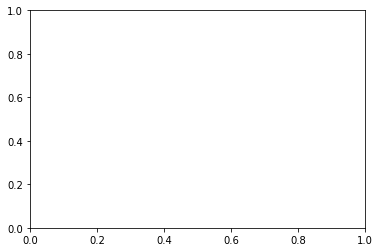

In [9]:
if __name__ == "__main__":
#     results = main()
#     expr = results[2][0]
#     print(expr)
#       PLOTANDO OS GRAFICOS
#     tree = gp.PrimitiveTree(expr)
#     candidate_function = toolbox.compile(tree)
#     original_function = lambda x: x**4 + x**3 + x**2 + x
#     plot(candidate_function, x, y)
    main()
    